TALLER 3. ANALISIS BIVARIADO PARA PROYECTO PREDICCION DE PRECIO DE CIERRE DE BTC VS USDT

Estudiante: Albin Rivera Paja

1. SELECCION Y DESCRIPCION DE LAS DOS VARIABLES SELECCIONADAS. 

<b>CLOSE</b>: Precio de cierre del activo financiero, de tipo float64. 

<b>VOLUME</b>: Cantidad de unidades vendidas y compradas en un lapso de tiempo, de tipo float64.

1.1. EXPLORACION DE DATOS

Lo primero que se realiza es la carga de librerias y la base de datos:

In [1]:
#Carga de librerias
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
#Carga de base de datos
path="Data/Bronce.precio_BTCUSDT_4h_Binance.csv"
df = pd.read_csv(path)[['timestamp','close', 'volume']]
df['fecha'] = pd.to_datetime(df['timestamp'], unit='ms')
df



,timestamp,close,volume,fecha
0,1502956800000,4427.30,63.619882,2017-08-17 08:00:00
1,1502971200000,4352.34,174.562001,2017-08-17 12:00:00
2,1502985600000,4325.23,225.109716,2017-08-17 16:00:00
3,1503000000000,4285.08,249.769913,2017-08-17 20:00:00
4,1503014400000,4292.39,276.193043,2017-08-18 00:00:00
...,...,...,...,...
15340,1723867200000,59248.00,1106.844530,2024-08-17 04:00:00
15341,1723881600000,59137.12,1327.011360,2024-08-17 08:00:00
15342,1723896000000,59388.11,1490.864120,2024-08-17 12:00:00
15343,1723910400000,59473.19,1157.010550,2024-08-17 16:00:00


In [3]:
# Identificar la cantidad de columnas y filas del dataframe
df.shape

(15345, 4)

In [4]:
#Visualizar las primeras 5 filas del dataframe
df.head()
     

,timestamp,close,volume,fecha
0,1502956800000,4427.30,63.619882,2017-08-17 08:00:00
1,1502971200000,4352.34,174.562001,2017-08-17 12:00:00
2,1502985600000,4325.23,225.109716,2017-08-17 16:00:00
3,1503000000000,4285.08,249.769913,2017-08-17 20:00:00
4,1503014400000,4292.39,276.193043,2017-08-18 00:00:00


In [5]:
#Visualizar las últimas 5 filas del dataframe
df.tail()

,timestamp,close,volume,fecha
15340,1723867200000,59248.00,1106.84453,2024-08-17 04:00:00
15341,1723881600000,59137.12,1327.01136,2024-08-17 08:00:00
15342,1723896000000,59388.11,1490.86412,2024-08-17 12:00:00
15343,1723910400000,59473.19,1157.01055,2024-08-17 16:00:00
15344,1723924800000,59306.24,472.29437,2024-08-17 20:00:00


In [6]:
# Identificar el tipo de dato de df
df.dtypes

timestamp             int64
close               float64
volume              float64
fecha        datetime64[ns]
dtype: object

1.2. BUSQUEDA Y TRATAMIENTO DE DUPLICADOS

In [7]:
#Verificar duplicidad en los datos
num_duplicados = df.duplicated(subset='fecha').sum()
print(f"Cantidad de datos duplicados: {num_duplicados}")

Cantidad de datos duplicados: 15


Debido a que se identifican 15 datos duplicados en el dataframe, se procede a verificar una muestra de dichos duplicados:

In [8]:
# Verificar y mostrar una muestra de los datos duplicados
duplicados = df[df.duplicated(subset='fecha', keep=False)]
print("Datos duplicados:")
duplicados.head()  # Mostrar las primeras filas de los datos duplicados

Datos duplicados:


,timestamp,close,volume,fecha
999,1517342400000,10237.51,4737.906346,2018-01-30 20:00:00
1000,1517342400000,10237.51,4737.906346,2018-01-30 20:00:00
1999,1531872000000,7457.03,9867.367577,2018-07-18 00:00:00
2000,1531872000000,7457.03,9867.367577,2018-07-18 00:00:00
2999,1546272000000,3687.47,6179.613282,2018-12-31 16:00:00


Ahora se procede a eliminar los duplicados para limpiar el dataframe:

In [9]:
# Eliminar duplicados a partir de la columna fecha
df.drop_duplicates(subset='fecha', inplace=True)  

Se verifica que efectivamente se haya eliminado los duplicados:

In [10]:
#Verificar duplicidad en los datos
num_duplicados = df.duplicated(subset='fecha').sum()
print(f"Cantidad de datos duplicados: {num_duplicados}")

Cantidad de datos duplicados: 0


1.3. IDENTIFICACION Y TRATAMIENTO DE VALORES UNICOS Y DATOS FALTANTES

Es importante asegurarse de como se comportan los datos en el dataframe, es decir si contamos con valores unicos o caso contrario vemos repetición de datos en el mismo, de acuerdo a lo siguiente, se puede evidenciar que en general todos los datos tienden a ser unicos, sin embargo como era de esperarse se pueden repetir datos en las variables open, high, low y close ya que el comportamiento del activo puede tomar un mismo valor n veces. 

In [11]:
#Identificar datos unicos
df.nunique()

timestamp    15330
close        15211
volume       15330
fecha        15330
dtype: int64

Con lo anterior tambien podemos identificar la existencia de datos faltantes, lo cual sera verificado a continuación:

In [12]:
# Identificar datos faltantes
df.set_index('fecha', inplace=True)  # Establecer timestamp como índice
df = df.resample('4h').asfreq()  # Re-samplear a intervalos de 4 horas
missing_data = df[df.isnull().any(axis=1)]  # Filtrar filas con datos faltantes

print("Datos faltantes:")
print(missing_data)

# Imprimir la cantidad total de filas con datos faltantes
print("\nCantidad total de filas con datos faltantes:", missing_data.shape[0])

Datos faltantes:
                     timestamp  close  volume
fecha                                        
2018-02-08 04:00:00        NaN    NaN     NaN
2018-02-08 08:00:00        NaN    NaN     NaN
2018-02-08 12:00:00        NaN    NaN     NaN
2018-02-08 16:00:00        NaN    NaN     NaN
2018-02-08 20:00:00        NaN    NaN     NaN
2018-02-09 00:00:00        NaN    NaN     NaN
2018-02-09 04:00:00        NaN    NaN     NaN
2018-06-26 04:00:00        NaN    NaN     NaN
2018-06-26 08:00:00        NaN    NaN     NaN
2018-07-04 04:00:00        NaN    NaN     NaN
2018-11-14 04:00:00        NaN    NaN     NaN
2019-03-12 04:00:00        NaN    NaN     NaN
2019-05-15 04:00:00        NaN    NaN     NaN
2019-05-15 08:00:00        NaN    NaN     NaN
2019-08-15 04:00:00        NaN    NaN     NaN
2020-02-19 12:00:00        NaN    NaN     NaN

Cantidad total de filas con datos faltantes: 16


Efectivamente se identifica la ausencia de 16 datos, traduciendose esto en 16 filas completas que no fueron registradas. A continuación verificamos cuando en porcentaje representan los datos faltantes en el dataframe:

In [13]:
# Calcular el porcentaje de datos NaN en cada columna
porcentaje_nan = df.isna().mean() * 100
print("Porcentaje de datos NaN por columna:")
print(porcentaje_nan)

Porcentaje de datos NaN por columna:
timestamp    0.104262
close        0.104262
volume       0.104262
dtype: float64


A partir de la identificación de los datos faltantes, y del taller 2 se tomó inicialmente la interpolacion Spline, por tener el mejor RMSE. Sin embargo esta imputacion 
genera en la variable 'volume' valores negativos, que bajo el entendimiento del negocio el volume nunca puede ser negativo, por esta razón se toma como segunda opcion
de tratamiento la eliminacion, primero por que solamente los datos faltante representan el 0.104% y debido tambien a que el RMSE de esta solucion con relacion al RMSE
de la interpolacion Spline no infieren significativamente.

SOLUCION INTERPOLACION SPLINE

Este metodo de imputacion se aplica ya que los datos faltantes son pocos y estan dispersos en intervalos cortos, además de que los valores de la serie de tiempo cambian de manera no lineal. A continuación se muestra el proceso de interpolación Spline y se verifica que se haya imputado los NAN de la variable "close" y "volume":

In [14]:
# Crear una copia del DataFrame original
df_interpolated = df.copy()

# Aplicar la interpolación en la columna 'close', 'volume'
df_interpolated[['close', 'volume']] = df_interpolated[['close', 'volume']].interpolate(method='spline', order=2, s=1)

# Calcular el porcentaje de datos NaN en cada columna
porcentaje_nan = df_interpolated.isna().mean() * 100
print("Porcentaje de datos NaN por columna:")
print(porcentaje_nan)

Porcentaje de datos NaN por columna:
timestamp    0.104262
close        0.000000
volume       0.000000
dtype: float64


Descripción estadística básica con interpolacion Spline

In [15]:
# Descripción estadística básica
descripcion = df_interpolated[['close', 'volume']].describe()
print("Descripción estadística del precio de cierre de BTC:")
print(descripcion)

Descripción estadística del precio de cierre de BTC:
              close         volume
count  15346.000000   15346.000000
mean   24404.172727   11682.022051
std    19052.174728   15265.392824
min     2919.000000  -11994.204304
25%     8245.907500    4122.598318
50%    19024.515000    6967.915437
75%    38244.755000   12542.368631
max    73349.240000  284711.694213


Como se menciono anteriormente en vista de que se identifico volumen con valores negativos (min: -11994.2) despues de aplicar la interpolacion Spline (Ver Descripcion estadistica basica) y que para el negocio esto no existe, se procede a aplicar la solucion de eliminacion de datos faltantes:

SOLUCION ELIMINACION DE DATOS FALTANTES

In [16]:
# Crear una copia del DataFrame original
df_nulos = df.copy()

# Eliminar filas con datos faltantes
df_sin_nulos = df_nulos.dropna()

# Mostrar la cantidad de filas antes y después de eliminar los datos nulos
print(f"Cantidad de filas antes de eliminar nulos: {df.shape[0]}")
print(f"Cantidad de filas después de eliminar nulos: {df_sin_nulos.shape[0]}")

# Mostrar un ejemplo de los datos sin nulos
print(df_sin_nulos.head())

Cantidad de filas antes de eliminar nulos: 15346
Cantidad de filas después de eliminar nulos: 15330
                        timestamp    close      volume
fecha                                                 
2017-08-17 08:00:00  1.502957e+12  4427.30   63.619882
2017-08-17 12:00:00  1.502971e+12  4352.34  174.562001
2017-08-17 16:00:00  1.502986e+12  4325.23  225.109716
2017-08-17 20:00:00  1.503000e+12  4285.08  249.769913
2017-08-18 00:00:00  1.503014e+12  4292.39  276.193043


Descripción estadística básica con Eliminacion de datos faltantes

In [17]:
# Descripción estadística básica
descripcion_df_Nulos = df_sin_nulos[['close', 'volume']].describe()
print("Descripción estadística del precio de cierre de BTC:")
print(descripcion_df_Nulos)

Descripción estadística del precio de cierre de BTC:
              close         volume
count  15330.000000   15330.000000
mean   24421.608021   11694.940039
std    19054.401615   15266.761527
min     2919.000000       0.000000
25%     8257.200000    4126.861440
50%    19051.700000    6973.718980
75%    38282.377500   12564.660878
max    73349.240000  284711.694213


Finalmente a partir de la solucion de datos faltantes, se evidencia coherencia en los datos para la variable volume

2. ANALISIS ESTADISTICO Y GRAFICO BIVARIADO

In [18]:
# Calcular la mediana, varianza y desviación estándar

mediana = df_sin_nulos[['close', 'volume']].median()
varianza = df_sin_nulos[['close', 'volume']].var()

print("Mediana de Close: {} ---- Mediana de Volume: {}".format(mediana.iloc[0], mediana.iloc[1]))
print("Varianza de Close: {} ---- Varianza de Volume: {}".format(varianza.iloc[0], varianza.iloc[1]))

Mediana de Close: 19051.7 ---- Mediana de Volume: 6973.71898
Varianza de Close: 363070220.9235667 ---- Varianza de Volume: 233074007.5311717


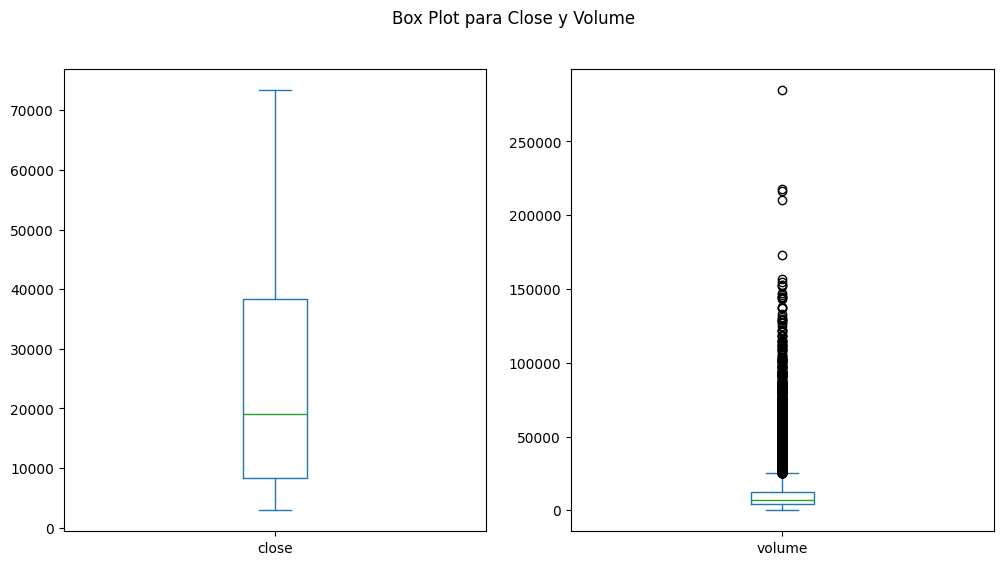

In [19]:
# Crear una figura con subplots para 'close' y 'volume'
df_sin_nulos[['close', 'volume']].plot(kind='box', 
                                          subplots=True, 
                                          layout=(1, 2),  # 1 fila, 2 columnas
                                          sharex=False, 
                                          sharey=False, 
                                          figsize=(12, 6), 
                                          title='Box Plot para Close y Volume')

# Mostrar el gráfico
plt.show()

La grafica de cajas para las variables "close" y "volume", indican lo siguiente:

Close:
La mediana está alrededor de 19051.7.
El 50% central de los datos se encuentra entre aproximadamente 8,000 y 38,000.
Hay algunos valores atípicos por encima, con el máximo cerca de 73,000.

volume:
La mediana es relativamente baja (6973.7).
El 50% central de los datos está muy concentrado en valores bajos.
Hay una gran cantidad de valores atípicos, con algunos extremos llegando hasta cerca de 275,000.

De acuerdo a lo anterior, mientras que los precios de cierre muestran una variabilidad moderada, el volumen presenta una variabilidad extrema con muchos días de volumen bajo y algunos días con volumen extremamente altos, esto evidencia la alta volatilidad que tiene este activo financiero.

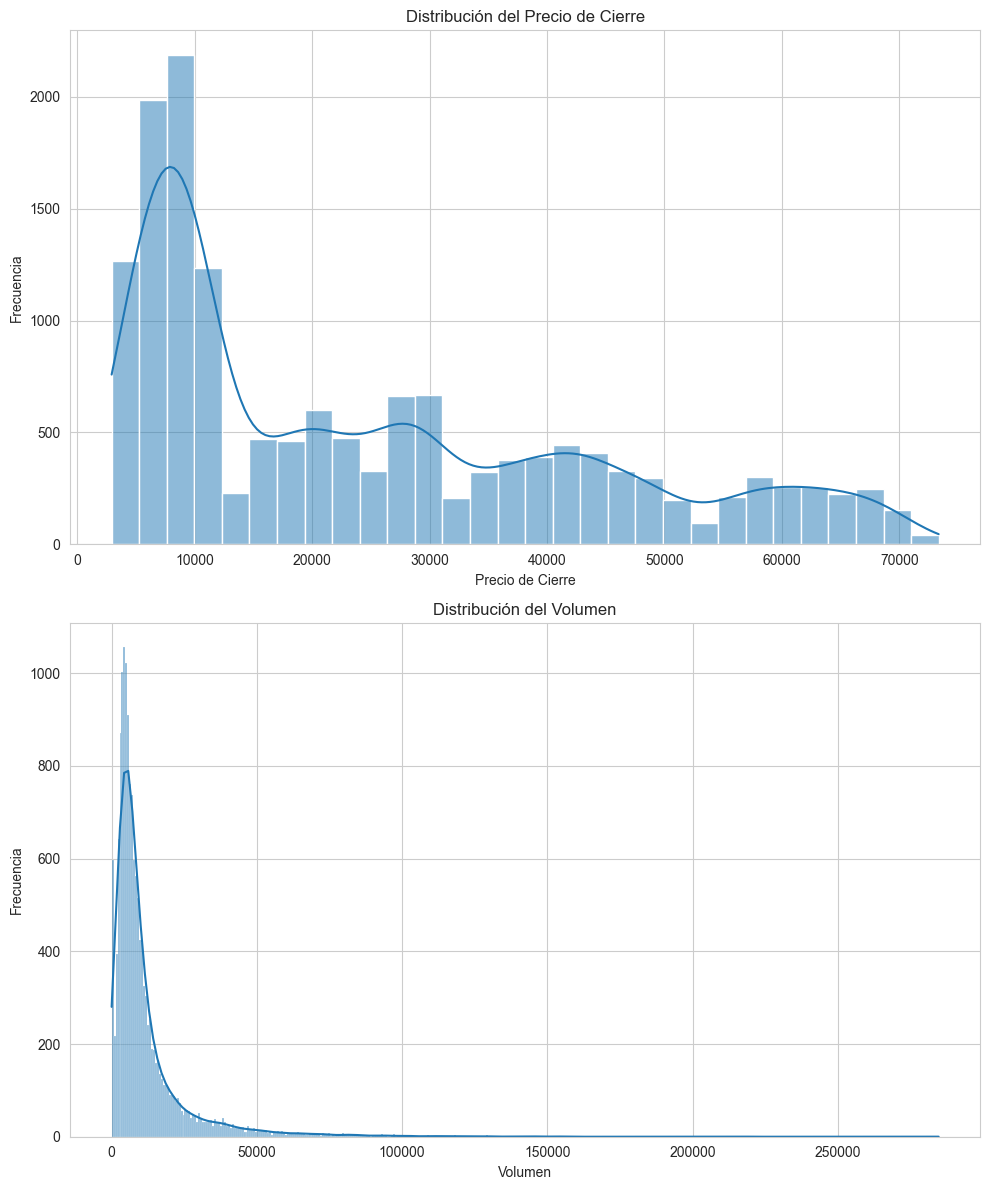

In [20]:
# Configuración del estilo de seaborn
sns.set_style("whitegrid")

# Creando la figura con dos subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Gráfico para 'close'
sns.histplot(df_sin_nulos['close'], kde=True, ax=ax1)
ax1.set_title('Distribución del Precio de Cierre')
ax1.set_xlabel('Precio de Cierre')
ax1.set_ylabel('Frecuencia')

# Gráfico para 'volume'
sns.histplot(df_sin_nulos['volume'], kde=True, ax=ax2)
ax2.set_title('Distribución del Volumen')
ax2.set_xlabel('Volumen')
ax2.set_ylabel('Frecuencia')

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

Grafico de Close:
La distribución del precio de cierre tiene una asimetría positiva o sesgo a la derecha. Esto significa que la cola derecha de la distribución es más larga.
De igual manera la mayoria de los datos con frecuencias más altas se encuentran en el rango de precios entre los $10,000 a los $20,000, pero hay una cola hacia la derecha que se extiende hacia precios más altos, aunque con menor frecuencia.
Indicando que, aunque los precios altos han ocurrido, son menos frecuentes que los precios más bajos.

Gráfico de Volume:
La distribución del volumen también muestra asimetría positiva o sesgo a la derecha, pero de manera más extrema que el precio de cierre.
La mayoría de los volúmenes son bajos, con una larga cola que se extiende hacia volúmenes más altos.
Mostrando que los volúmenes extremadamente altos son raros, mientras los volúmenes bajos son comunes.
La curva está muy concentrada cerca de cero y se va desvaneciendo lentamente a medida que el volumen aumenta.

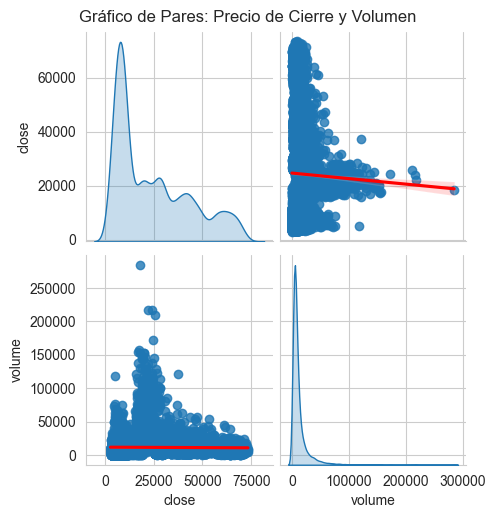

In [38]:
# Gráfico de pares (pair plot)
sns.pairplot(df_sin_nulos[['close', 'volume']], kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle('Gráfico de Pares: Precio de Cierre y Volumen', y=1.02)
plt.show()

En la grafica de pares para la variable close y volume donde se puede observar la relación entre estas dos variables y la distribución individual de cada una

Distribuciones Individuales:

Distribución de close:
* Se observa en el gráfico ubicado en parte superior izquierda un gráfico de densidad, donde la distribución es asimétrica a la derecha (sesgo positivo), con una gran concentración de la variable close en los rangos bajos, entre aproximadamente 0 y 25,000.

Distribución de volume:
* Se evidencia en el gráfico de la parte inferior derecha un grafico de densidad con una distribución de la variable volume, la cual es altamente asimétrica a la derecha, lo que indica que la mayoría de los volúmenes son bajos, con algunos volúmenes extremadamente altos reiterando el comportamiento arrojado por las graficas anteriores.

Relación entre close y volume:
* En los gráficos superior derecha e inferior izquierda, se muestra la relación entre la variable close y volume, esta relación muestra ser negativa, aunque no muy fuerte, ya que la línea de regresión (en rojo) tiene una pendiente ligeramente descendente.

* Los puntos están concentrados en las zonas de precios bajos y volúmenes bajos, con algunos puntos dispersos en los volúmenes más altos.

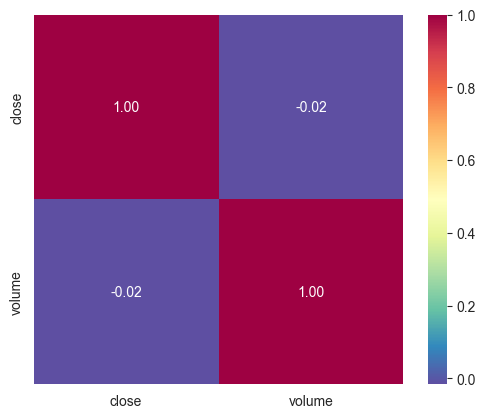

In [24]:
# Correlacion entre variables

corrmat = df_sin_nulos[['close', 'volume']].corr()
hm = sns.heatmap(corrmat, 
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=['close', 'volume'], 
                 xticklabels=['close', 'volume'], 
                 cmap="Spectral_r")
plt.show()

Apartir del grafico de pares y de la matriz de correlacion, se puede decir que aunque existe una ligera correlación negativa entre las variables close y volume, no parece ser una relación lineal fuerte. Esto puede indicar que un aumento en el volumen no está necesariamente asociado con un aumento en el precio de cierre, y viceversa.

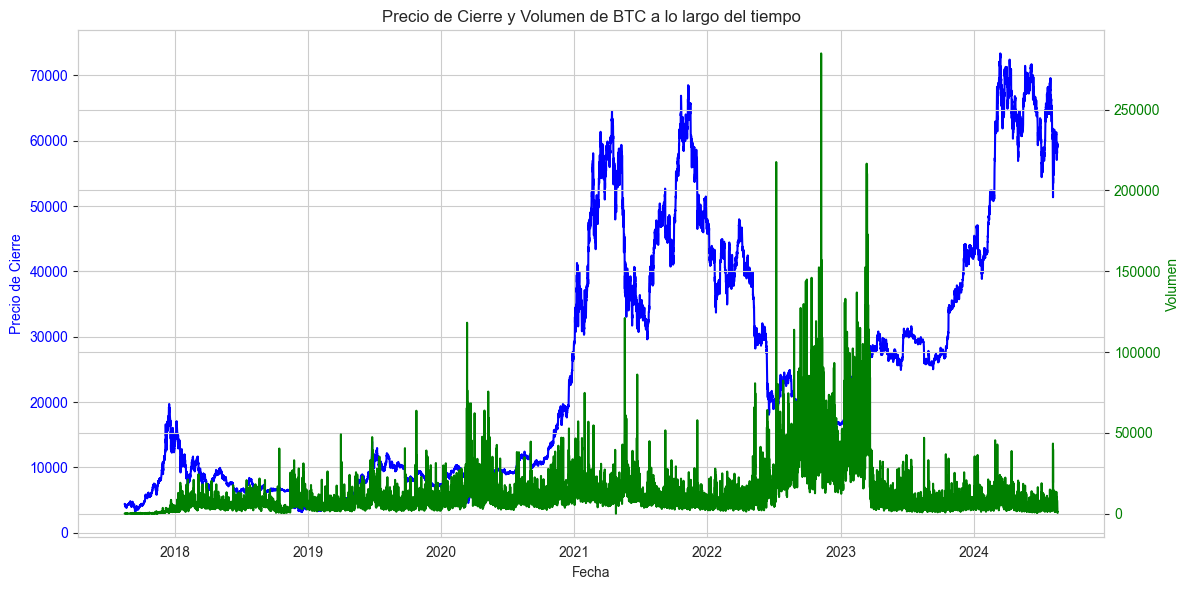

In [35]:
# Crear una nueva columna para la fecha utilizando .loc
df_sin_nulos.loc[:, 'fecha'] = df_sin_nulos.index

# Crear la figura y el primer eje Y
fig, ax1 = plt.subplots(figsize=(12, 6))

# Graficar el precio de cierre en el primer eje Y (ax1)
ax1.plot(df_sin_nulos['fecha'], df_sin_nulos['close'], color='blue', label='Close')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio de Cierre', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True)

# Crear un segundo eje Y que comparte el mismo eje X
ax2 = ax1.twinx()
ax2.plot(df_sin_nulos['fecha'], df_sin_nulos['volume'], color='green', label='Volume')
ax2.set_ylabel('Volumen', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Título y leyendas
plt.title('Precio de Cierre y Volumen de BTC a lo largo del tiempo')
fig.tight_layout()  # Ajusta el layout para que no se superpongan las etiquetas

plt.show()

La grafica anterior muestra una serie temporal que ilustra la evolución de la variable close (en azul) y la variable volume (en verde) de Bitcoin (BTC) a lo largo del tiempo, desde aproximadamente 2017 hasta 2024:

1. Evolución de close:

2017-2018: Se observa un gran pico en el precio de cierre a finales de 2017, alcanzando valores cercanos a los 20,000 USD, seguido de una corrección significativa en 2018.

2019-2020: El precio se mantiene relativamente estable, con fluctuaciones menores hasta 2020.

2021: Hay un repunte significativo en el precio, alcanzando un nuevo máximo histórico alrededor de los 60,000 USD en la primera mitad de 2021. Esto es seguido por una corrección en el precio a mediados del año.

2021-2022: El precio vuelve a subir hacia finales de 2021, alcanzando nuevamente niveles cercanos a los 60,000 USD antes de caer de manera constante en 2022.

2023-2024: Durante estos años, el precio experimenta una recuperación, aunque no alcanza los máximos anteriores.

2. Evolución del Volume:

Volumen y Precio: Se puede observar que los picos en el volumen de transacciones tienden a coincidir con momentos de gran volatilidad en el precio de cierre. Por ejemplo, antes de los grandes aumentos de precio, el volumen de transacciones aumenta significativamente, indicando un alto nivel de actividad en el mercado.

Picos Específicos: Durante los picos de precios en 2021, el volumen también muestra grandes picos, lo que sugiere una fuerte participación del mercado en estos periodos. Sin embargo, en algunos otros momentos, como en la segunda mitad de 2022 y 2023, hay un aumento en el volumen, pero no necesariamente una correlación directa con el aumento del precio.

3. CONCLUSIONES

* Los picos en el volumen de transacciones tienden a coincidir con movimientos significativos en el precio de cierre. Esto sugiere que el volumen puede ser un indicador importante de la actividad en el mercado, precediendo o coincidiendo con cambios bruscos en el precio.

* Durante periodos de alta volatilidad en el precio, como en los repuntes y caídas significativas de 2017, 2021, y 2022, el volumen de transacciones mostró aumentos marcados, lo que refleja un incremento en la participación del mercado y la especulación.


* A pesar de la alta volatilidad y las correcciones significativas que ha experimentado Bitcoin, la tendencia general del precio de cierre a lo largo de los años ha sido al alza, con máximos históricos alcanzados en 2021.

* El mercado de Bitcoin parece operar en ciclos, con periodos de rápido crecimiento seguidos por correcciones prolongadas. Estos ciclos podrían ser influenciados por factores macroeconómicos, cambios regulatorios, y eventos globales, entre otros.


* El volumen de transacciones es un factor clave en la volatilidad del precio de Bitcoin. Altos volúmenes suelen estar asociados con fluctuaciones más amplias en el precio, lo que puede ser indicativo de una mayor incertidumbre o especulación en el mercado.

* Por otro lado, en periodos de menor volumen, el precio de Bitcoin parece estabilizarse o mostrar menor volatilidad, lo que puede estar relacionado con una menor actividad especulativa.


* Los inversores y traders pueden utilizar el volumen de transacciones como un indicador para anticipar posibles movimientos en el precio de Bitcoin. Un aumento repentino en el volumen puede señalar un cambio inminente en la dirección del precio.

* Dado que los picos de volumen han precedido importantes movimientos de precio en el pasado, monitorear el volumen puede ofrecer ventajas estratégicas en la toma de decisiones de inversión.

* Finalmente se puede decir que el analisis estadistico y grafico resalta la naturaleza cíclica y volátil de Bitcoin, con el volumen de transacciones desempeñando un papel crucial en la dinámica del precio.